In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import networkx.algorithms.community as nx_comm
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import scipy.sparse as sp
import random
import leidenalg
import igraph as ig
from collections import Counter, defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix
import xgboost as xgb
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.inspection import permutation_importance
from torch_geometric.nn import GAE, GCNConv
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, train_test_split_edges

# Read file

In [ ]:
users = pd.read_csv(r"D:\social_network\data_new\users.csv")
edges = pd.read_csv(r"D:\social_network\data_new\collaboration_edges.csv")

# EDA

In [ ]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          5682 non-null   object
 1   login            5682 non-null   object
 2   name             4717 non-null   object
 3   bio              2433 non-null   object
 4   company          2469 non-null   object
 5   location         3148 non-null   object
 6   created_at       5682 non-null   object
 7   updated_at       5682 non-null   object
 8   public_repos     5682 non-null   int64 
 9   followers_count  5682 non-null   int64 
 10  following_count  5682 non-null   int64 
 11  organizations    1459 non-null   object
dtypes: int64(3), object(9)
memory usage: 532.8+ KB


In [ ]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048503 entries, 0 to 1048502
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   user_A              1048503 non-null  object
 1   user_B              1048503 non-null  object
 2   common_repos        1048503 non-null  object
 3   common_repos_count  1048503 non-null  int64 
 4   commit_count_A      1048503 non-null  int64 
 5   commit_count_B      1048503 non-null  int64 
 6   weight              1048503 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 56.0+ MB


In [ ]:
users.describe()

,public_repos,followers_count,following_count
count,5682.000000,5682.000000,5682.000000
mean,52.506160,162.814502,30.555966
std,183.082042,1010.738013,122.131719
min,0.000000,0.000000,0.000000
25%,11.000000,4.000000,0.000000
50%,26.000000,18.000000,4.000000
75%,54.000000,67.000000,21.000000
max,8973.000000,32765.000000,4625.000000


In [ ]:
edges.describe()

,common_repos_count,commit_count_A,commit_count_B,weight
count,1.048503e+06,1.048503e+06,1.048503e+06,1.048503e+06
mean,1.008232e+00,3.042305e+01,1.046376e+01,1.008232e+00
std,9.847639e-02,2.048280e+02,5.537450e+01,9.847639e-02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00
75%,1.000000e+00,8.000000e+00,5.000000e+00,1.000000e+00
max,8.000000e+00,1.237600e+04,7.708000e+03,8.000000e+00


In [ ]:
print(users.isnull().sum())
print(edges.isnull().sum())

user_id               0
login                 0
name                965
bio                3249
company            3213
location           2534
created_at            0
updated_at            0
public_repos          0
followers_count       0
following_count       0
organizations      4223
dtype: int64
user_A                0
user_B                0
common_repos          0
common_repos_count    0
commit_count_A        0
commit_count_B        0
weight                0
dtype: int64


In [ ]:
print(users.duplicated().sum())
print(edges.duplicated().sum())

0
0


In [ ]:
# Chuyển kiểu dữ liệu của các cột thời gian sang datetime trong users và edges
users['created_at'] = pd.to_datetime(users['created_at'])
users['updated_at'] = pd.to_datetime(users['updated_at'])


# lấy thông tin cần thiết

In [ ]:
# Lấy thông tin cần thiết từ users để phân tích mạng xã hội
neccessary_user_graph = users[['user_id','login']]

In [ ]:
# Lấy thông tin cần thiết từ edges để phân tích mạng xã hội
neccessary_edge_graph = edges[['user_A', 'user_B', 'weight']]

In [ ]:
# Tạo graph với 2500 node
def create_collaboration_network(edges_df, users_df):
    """
    Tạo đồ thị mạng lưới hợp tác giữa các developer từ dữ liệu edges (có trọng số).
    Mỗi cạnh (edge) đại diện cho một mối quan hệ hợp tác giữa hai user.
    """

    # Tạo graph
    G = nx.Graph()

    # Nếu có cột 'weight' thì dùng weighted edges, ngược lại dùng weight=1
    if 'weight' in edges_df.columns:
        edges = [(row['user_A'], row['user_B'], row['weight']) for _, row in edges_df.iterrows()]
        G.add_weighted_edges_from(edges)
    else:
        edges = [(row['user_A'], row['user_B'], 1) for _, row in edges_df.iterrows()]
        G.add_weighted_edges_from(edges)

    print(f"\n=== Collaboration Network Created ===")
    print(f"Total nodes: {G.number_of_nodes()}")
    print(f"Total edges: {G.number_of_edges()}")
    print(f"Network density: {nx.density(G):.4f}")

    # Thêm thuộc tính node từ users_df
    user_dict = users_df.set_index('user_id').to_dict('index')
    missing_users = 0

    for node in G.nodes():
        if node in user_dict:
            for key, value in user_dict[node].items():
                G.nodes[node][key] = value
        else:
            # Nếu user không có trong users.csv
            G.nodes[node]['login'] = f"unknown_{node}"
            G.nodes[node]['name'] = f"User_{node}"
            missing_users += 1

    # if missing_users > 0:
        # print(f"Warning: {missing_users} users in edges not found in users.csv")

    # Kiểm tra cấu trúc mạng
    if nx.is_connected(G):
        print(f"Graph is connected")
        print(f"Diameter: {nx.diameter(G)}")
        print(f"Average shortest path length: {nx.average_shortest_path_length(G):.2f}")
    else:
        num_components = nx.number_connected_components(G)
        largest_cc = max(nx.connected_components(G), key=len)
        print(f"Graph has {num_components} connected components")
        print(f"Largest component size: {len(largest_cc)} nodes")

    return G

In [ ]:
G_full = create_collaboration_network(
    edges_df=neccessary_edge_graph,
    users_df=neccessary_user_graph
)


=== Collaboration Network Created ===
Total nodes: 8654
Total edges: 1048503
Network density: 0.0280
Graph has 11 connected components
Largest component size: 8507 nodes


In [ ]:
# Hàm chọn ra 2500 node quan trọng nhất
def select_best_2500_nodes(edges_df, users_df):
    """
    Chọn ra 2500 node (developer) quan trọng nhất dựa trên các chỉ số:
      - Degree Centrality (weighted)
      - PageRank (weighted)
      - Betweenness Centrality (weighted, sample)
    Từ đó tạo ra subgraph 2500 node này + edges + thông tin user tương ứng.
    """

    # Tạo full graph từ bảng edges có trọng số
    G_full = nx.Graph()
    edges = [(row['user_A'], row['user_B'], row['weight']) for _, row in edges_df.iterrows()]
    G_full.add_weighted_edges_from(edges)

    print(f"Full network: {G_full.number_of_nodes()} nodes, {G_full.number_of_edges()} edges")

    # Tính các chỉ số trung tâm (centrality) có trọng số
    print("\nCalculating weighted node importance scores...")

    degree_cent = dict(G_full.degree(weight='weight'))
    pagerank = nx.pagerank(G_full, weight='weight')

    # Giảm mẫu của betweenness để tránh chạy quá lâu
    if G_full.number_of_nodes() < 5000:
        betweenness = nx.betweenness_centrality(G_full, weight='weight', k=200)  # giảm từ 500 → 200
    else:
        betweenness = {node: 0 for node in G_full.nodes()}

    # Tính điểm tổng hợp (importance score)
    importance_scores = {}
    max_deg = max(degree_cent.values()) if degree_cent else 1
    max_pr = max(pagerank.values()) if pagerank else 1
    max_bt = max(betweenness.values()) if betweenness else 1

    for node in G_full.nodes():
        importance_scores[node] = (
            0.4 * (degree_cent[node] / max_deg) +  # 40% độ kết nối
            0.4 * (pagerank[node] / max_pr) +      # 40% PageRank
            0.2 * (betweenness[node] / max_bt if max_bt > 0 else 0)  # 20% trung gian
        )

    # Chọn top 2500 node
    TOP_N = 2500
    top_nodes = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    selected_node_ids = [node for node, _ in top_nodes]

    print(f"\nSelected top {TOP_N} nodes based on weighted importance score")
    print(f"Top 5 nodes: {selected_node_ids[:5]}")

    # Tạo subgraph 2500 node
    G_sub = G_full.subgraph(selected_node_ids).copy()

    # Lọc lại edges + users tương ứng
    edges_sub = edges_df[
        (edges_df['user_A'].isin(selected_node_ids)) &
        (edges_df['user_B'].isin(selected_node_ids))
    ].copy()

    users_sub = users_df[users_df['user_id'].isin(selected_node_ids)].copy()

    # Thêm các chỉ số vào bảng user
    users_sub['importance_score'] = users_sub['user_id'].map(lambda x: importance_scores.get(x, 0))
    users_sub['degree'] = users_sub['user_id'].map(lambda x: degree_cent.get(x, 0))
    users_sub['pagerank'] = users_sub['user_id'].map(lambda x: pagerank.get(x, 0))
    users_sub['betweenness'] = users_sub['user_id'].map(lambda x: betweenness.get(x, 0))
    users_sub = users_sub.sort_values('importance_score', ascending=False)

    # In thống kê
    print(f"\n{TOP_N}-Node Network Statistics:")
    print(f"   Nodes: {G_sub.number_of_nodes()}")
    print(f"   Edges: {G_sub.number_of_edges()}")
    print(f"   Density: {nx.density(G_sub):.3f}")
    print(f"   Average degree: {sum(dict(G_sub.degree(weight='weight')).values()) / G_sub.number_of_nodes():.2f}")

    return G_sub, edges_sub, users_sub


# link prediction

In [ ]:
class FeatureExtractor:
    """
    Class để trích xuất các đặc trưng cho machine learning
    """
    def __init__(self, G):  # Fixed: Accept G as a parameter
        self.G = G
        self.node_features = self._compute_node_features()

    def _compute_node_features(self):
        """Tính toán các đặc trưng cấp nút"""
        features = {}

        # Basic features
        for node in self.G.nodes():
            features[node] = {
                'degree': self.G.degree(node),
                'clustering': nx.clustering(self.G, node),
            }

        # Centrality measures
        betweenness = nx.betweenness_centrality(self.G)
        closeness = nx.closeness_centrality(self.G)
        eigenvector = nx.eigenvector_centrality(self.G, max_iter=1000)
        pagerank = nx.pagerank(self.G)

        for node in self.G.nodes():
            features[node].update({
                'betweenness': betweenness[node],
                'closeness': closeness[node],
                'eigenvector': eigenvector[node],
                'pagerank': pagerank[node]
            })

        return features

    def extract_edge_features(self, edge_list):
        """Trích xuất đặc trưng cho danh sách cạnh"""
        features = []

        for u, v in edge_list:
            # Node-level features
            u_features = self.node_features[u]
            v_features = self.node_features[v]

            # Edge features
            edge_feat = {
                # Absolute differences
                'degree_diff': abs(u_features['degree'] - v_features['degree']),
                'clustering_diff': abs(u_features['clustering'] - v_features['clustering']),
                'betweenness_diff': abs(u_features['betweenness'] - v_features['betweenness']),
                'closeness_diff': abs(u_features['closeness'] - v_features['closeness']),
                'eigenvector_diff': abs(u_features['eigenvector'] - v_features['eigenvector']),
                'pagerank_diff': abs(u_features['pagerank'] - v_features['pagerank']),

                # Products (similarity)
                'degree_product': u_features['degree'] * v_features['degree'],
                'clustering_product': u_features['clustering'] * v_features['clustering'],
                'betweenness_product': u_features['betweenness'] * v_features['betweenness'],
                'closeness_product': u_features['closeness'] * v_features['closeness'],
                'eigenvector_product': u_features['eigenvector'] * v_features['eigenvector'],
                'pagerank_product': u_features['pagerank'] * v_features['pagerank'],

                # Sums
                'degree_sum': u_features['degree'] + v_features['degree'],
                'clustering_sum': u_features['clustering'] + v_features['clustering'],

                # Local similarity measures (from previous exercise)
                'common_neighbors': len(list(nx.common_neighbors(self.G, u, v))),
                'jaccard': self._jaccard_coefficient(u, v),
                'adamic_adar': self._adamic_adar_index(u, v),
                'resource_allocation': self._resource_allocation_index(u, v),

                # Distance features
                'shortest_path': self._shortest_path_length(u, v)
            }

            features.append(edge_feat)

        return pd.DataFrame(features)

    def _jaccard_coefficient(self, u, v):
        """Jaccard coefficient"""
        neighbors_u = set(self.G.neighbors(u))
        neighbors_v = set(self.G.neighbors(v))
        intersection = neighbors_u & neighbors_v
        union = neighbors_u | neighbors_v
        return len(intersection) / len(union) if len(union) > 0 else 0

    def _adamic_adar_index(self, u, v):
        """Adamic-Adar index"""
        common_neighbors = list(nx.common_neighbors(self.G, u, v))
        score = 0
        for neighbor in common_neighbors:
            degree = self.G.degree(neighbor)
            if degree > 1:
                score += 1 / np.log(degree)
        return score

    def _resource_allocation_index(self, u, v):
        """Resource allocation index"""
        common_neighbors = list(nx.common_neighbors(self.G, u, v))
        score = 0
        for neighbor in common_neighbors:
            degree = self.G.degree(neighbor)
            if degree > 0:
                score += 1 / degree
        return score

    def _shortest_path_length(self, u, v):
        """Shortest path length between two nodes"""
        try:
            return nx.shortest_path_length(self.G, u, v)
        except nx.NetworkXNoPath:
            return len(self.G.nodes()) + 1

In [ ]:
# Tách dữ liệu train/test
def split_edges_advanced(G, test_ratio=0.2, val_ratio=0.1, seed=42):
    """Tách cạnh thành train/validation/test"""
    random.seed(seed)
    np.random.seed(seed)

    edges = list(G.edges())
    random.shuffle(edges)

    n_test = int(len(edges) * test_ratio)
    n_val = int(len(edges) * val_ratio)
    n_train = len(edges) - n_test - n_val

    train_edges = edges[:n_train]
    val_edges = edges[n_train:n_train + n_val]
    test_edges = edges[n_train + n_val:]

    # Tạo đồ thị train
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())
    G_train.add_edges_from(train_edges)

    return G_train, train_edges, val_edges, test_edges

# Tạo negative samples
def generate_negative_samples_balanced(G, positive_edges, seed=42):
    """Tạo negative samples cân bằng"""
    random.seed(seed)
    negative_edges = []
    nodes = list(G.nodes())

    while len(negative_edges) < len(positive_edges):
        u = random.choice(nodes)
        v = random.choice(nodes)

        if (u != v and not G.has_edge(u, v) and
            (u, v) not in negative_edges and (v, u) not in negative_edges):
            negative_edges.append((u, v))

    return negative_edges

In [ ]:
G_train, train_edges, val_edges, test_edges = split_edges_advanced(G_full)
print(f"Train edges: {len(train_edges)}")
print(f"Validation edges: {len(val_edges)}")
print(f"Test edges: {len(test_edges)}")

# Tạo negative samples
train_negative = generate_negative_samples_balanced(G_train, train_edges)
val_negative = generate_negative_samples_balanced(G_train, val_edges)
test_negative = generate_negative_samples_balanced(G_train, test_edges)

Train edges: 733953
Validation edges: 104850
Test edges: 209700


In [ ]:
# Trích xuất features
feature_extractor = FeatureExtractor(G_train)

# Tạo datasets
train_features = feature_extractor.extract_edge_features(train_edges + train_negative)
train_labels = [1] * len(train_edges) + [0] * len(train_negative)

val_features = feature_extractor.extract_edge_features(val_edges + val_negative)
val_labels = [1] * len(val_edges) + [0] * len(val_negative)

test_features = feature_extractor.extract_edge_features(test_edges + test_negative)
test_labels = [1] * len(test_edges) + [0] * len(test_negative)

print(f"\nFeature shape: {train_features.shape}")
print(f"Features: {list(train_features.columns)}")

# Hiển thị thống kê features
print("\nThống kê features:")
print(train_features.describe())

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features.fillna(0))
X_val_scaled = scaler.transform(val_features.fillna(0))
X_test_scaled = scaler.transform(test_features.fillna(0))

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

### Logistic Regression

In [ ]:
# Định nghĩa mô hình
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Huấn luyện
model_lr.fit(X_train_scaled, y_train)

# Dự đoán
y_val_pred_lr = model_lr.predict(X_val_scaled)
y_val_proba_lr = model_lr.predict_proba(X_val_scaled)[:, 1]

y_test_pred_lr = model_lr.predict(X_test_scaled)
y_test_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Đánh giá
val_auc_lr = roc_auc_score(y_val, y_val_proba_lr)
test_auc_lr = roc_auc_score(y_test, y_test_proba_lr)

print(f"Logistic Regression - Validation AUC: {val_auc_lr:.4f}")
print(f"Logistic Regression - Test AUC: {test_auc_lr:.4f}")

Logistic Regression - Validation AUC: 0.9749
Logistic Regression - Test AUC: 0.9748


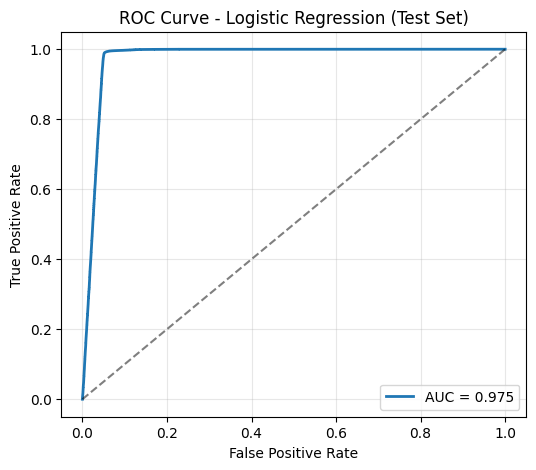

Biểu đồ ROC đã được lưu: roc_curve_logistic_regression.png


In [ ]:
# Trực quan hóa: ROC Curve
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_test_proba_lr)
plt.plot(fpr, tpr, label=f"AUC = {test_auc_lr:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_logistic_regression.png')
plt.show()
print("Biểu đồ ROC đã được lưu: roc_curve_logistic_regression.png")


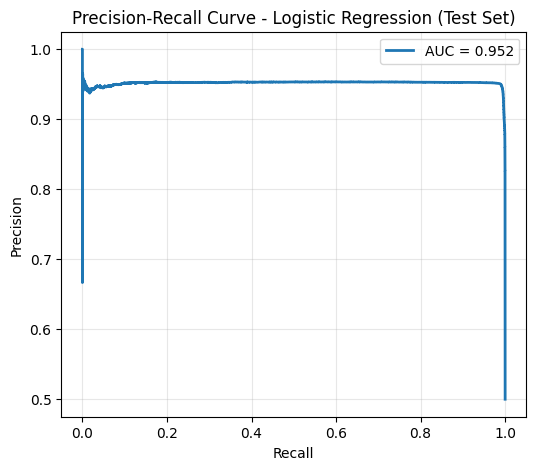

Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_logistic_regression.png


In [ ]:
# Trực quan hóa: Precision-Recall Curve
plt.figure(figsize=(6, 5))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_lr)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}", linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall_curve_logistic_regression.png')
plt.show()
print("Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_logistic_regression.png")

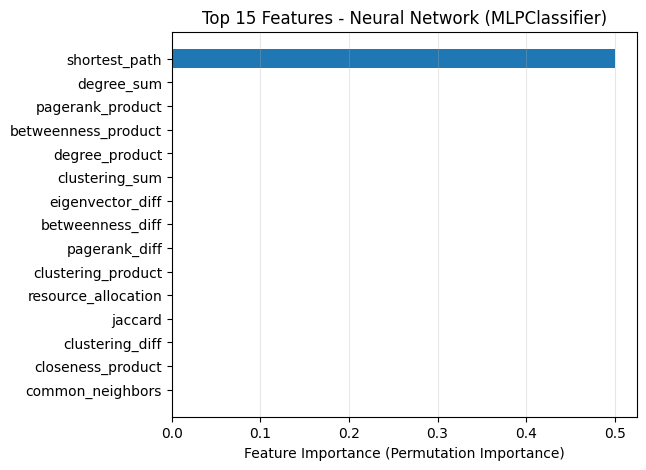

Biểu đồ Feature Importance đã được lưu: feature_importance_logistic_regression.png


In [ ]:
# Tính toán permutation importance
perm_importance = permutation_importance(model_lr, X_train_scaled, y_train, n_repeats=10, random_state=42)

# Tạo DataFrame cho feature importance
feature_importance = pd.DataFrame({
    'feature': train_features.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=True).tail(15)

# Trực quan hóa
plt.figure(figsize=(6, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance (Permutation Importance)')
plt.title('Top 15 Features - Neural Network (MLPClassifier)')
plt.grid(True, alpha=0.3, axis='x')
plt.savefig('feature_importance_logistic_regression.png')
plt.show()
print("Biểu đồ Feature Importance đã được lưu: feature_importance_logistic_regression.png")

### Random Forest

In [ ]:
# Định nghĩa mô hình
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện
model_rf.fit(X_train_scaled, y_train)

# Dự đoán
y_val_pred_rf = model_rf.predict(X_val_scaled)
y_val_proba_rf = model_rf.predict_proba(X_val_scaled)[:, 1]

y_test_pred_rf = model_rf.predict(X_test_scaled)
y_test_proba_rf = model_rf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Đánh giá
val_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

print(f"Random Forest - Validation AUC: {val_auc_rf:.4f}")
print(f"Random Forest - Test AUC: {test_auc_rf:.4f}")

Random Forest - Validation AUC: 0.5943
Random Forest - Test AUC: 0.5948


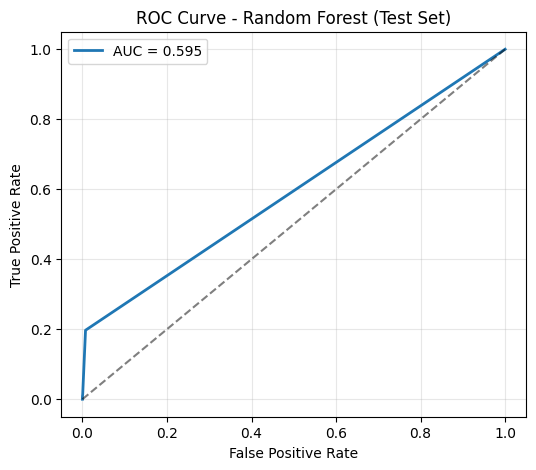

Biểu đồ ROC đã được lưu: roc_curve_random_forest.png


In [ ]:
# Trực quan hóa: ROC Curve
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_test_proba_rf)
plt.plot(fpr, tpr, label=f"AUC = {test_auc_rf:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_random_forest.png')
plt.show()
print("Biểu đồ ROC đã được lưu: roc_curve_random_forest.png")

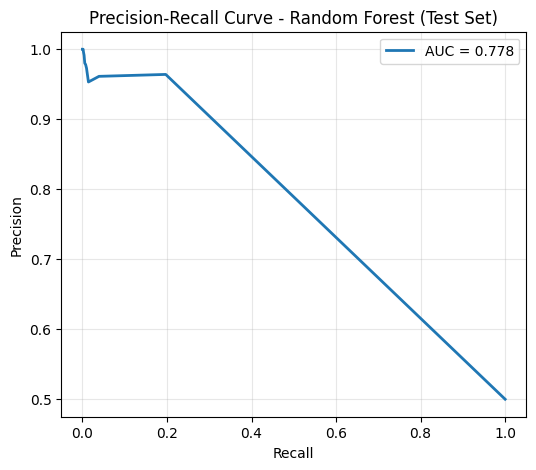

Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_random_forest.png


In [ ]:
# Trực quan hóa: Precision-Recall Curve
plt.figure(figsize=(6, 5))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_rf)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}", linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall_curve_random_forest.png')
plt.show()
print("Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_random_forest.png")

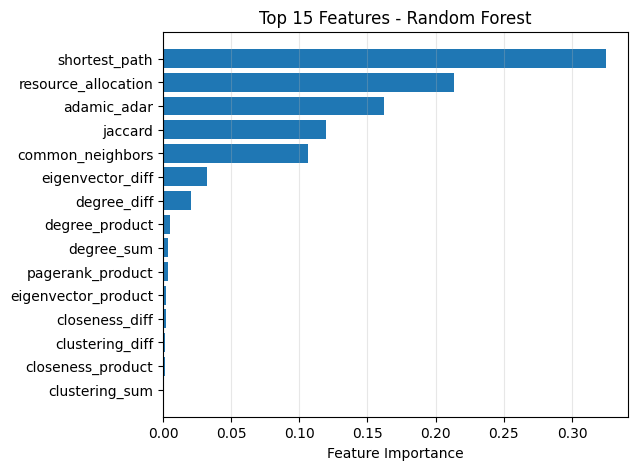

Biểu đồ Feature Importance đã được lưu: feature_importance_random_forest.png


In [ ]:
# Trực quan hóa: Feature Importance
plt.figure(figsize=(6, 5))
feature_importance = pd.DataFrame({
    'feature': train_features.columns,
    'importance': model_rf.feature_importances_
}).sort_values('importance', ascending=True).tail(15)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Random Forest')
plt.grid(True, alpha=0.3, axis='x')
plt.savefig('feature_importance_random_forest.png')
plt.show()
print("Biểu đồ Feature Importance đã được lưu: feature_importance_random_forest.png")

### Gradient Boosting

In [ ]:
# Định nghĩa mô hình
model_gb = GradientBoostingClassifier(random_state=42)

# Huấn luyện
model_gb.fit(X_train_scaled, y_train)

# Dự đoán
y_val_pred_gb = model_gb.predict(X_val_scaled)
y_val_proba_gb = model_gb.predict_proba(X_val_scaled)[:, 1]

y_test_pred_gb = model_gb.predict(X_test_scaled)
y_test_proba_gb = model_gb.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Đánh giá
val_auc_gb = roc_auc_score(y_val, y_val_proba_gb)
test_auc_gb = roc_auc_score(y_test, y_test_proba_gb)

print(f"Gradient Boosting - Validation AUC: {val_auc_gb:.4f}")
print(f"Gradient Boosting - Test AUC: {test_auc_gb:.4f}")

Gradient Boosting - Validation AUC: 0.4504
Gradient Boosting - Test AUC: 0.4498


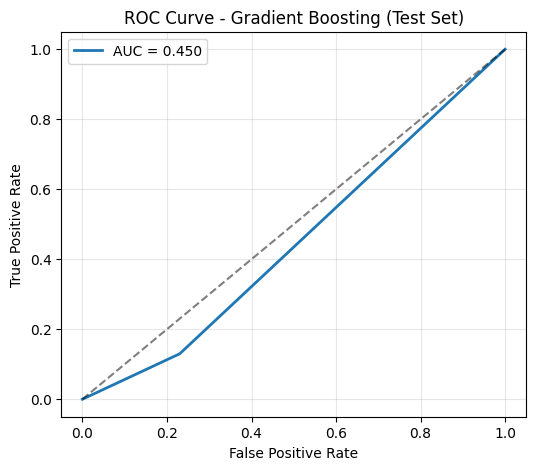

Biểu đồ ROC đã được lưu: roc_curve_gradient_boosting.png


In [ ]:
# Trực quan hóa: ROC Curve
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_test_proba_gb)
plt.plot(fpr, tpr, label=f"AUC = {test_auc_gb:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_gradient_boosting.png')
plt.show()
print("Biểu đồ ROC đã được lưu: roc_curve_gradient_boosting.png")

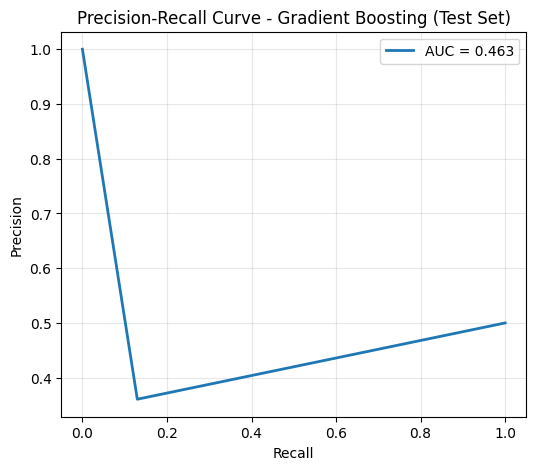

Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_gradient_boosting.png


In [ ]:
# Trực quan hóa: Precision-Recall Curve
plt.figure(figsize=(6, 5))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_gb)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}", linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Gradient Boosting (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall_curve_gradient_boosting.png')
plt.show()
print("Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_gradient_boosting.png")

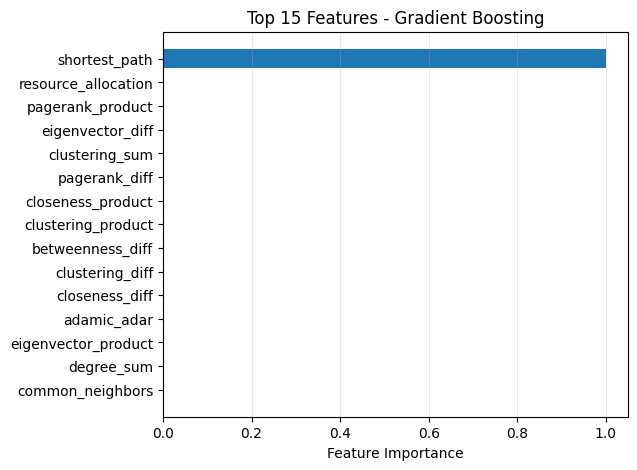

Biểu đồ Feature Importance đã được lưu: feature_importance_gradient_boosting.png


In [ ]:
# Trực quan hóa: Feature Importance
plt.figure(figsize=(6, 5))
feature_importance = pd.DataFrame({
    'feature': train_features.columns,
    'importance': model_gb.feature_importances_
}).sort_values('importance', ascending=True).tail(15)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - Gradient Boosting')
plt.grid(True, alpha=0.3, axis='x')
plt.savefig('feature_importance_gradient_boosting.png')
plt.show()
print("Biểu đồ Feature Importance đã được lưu: feature_importance_gradient_boosting.png")

### Neural Network (MLP)

In [ ]:
# Định nghĩa mô hình
model_nn = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)

# Huấn luyện
model_nn.fit(X_train_scaled, y_train)

# Dự đoán
y_val_pred_nn = model_nn.predict(X_val_scaled)
y_val_proba_nn = model_nn.predict_proba(X_val_scaled)[:, 1]

y_test_pred_nn = model_nn.predict(X_test_scaled)
y_test_proba_nn = model_nn.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Đánh giá
val_auc_nn = roc_auc_score(y_val, y_val_proba_nn)
test_auc_nn = roc_auc_score(y_test, y_test_proba_nn)

print(f"Neural Network - Validation AUC: {val_auc_nn:.4f}")
print(f"Neural Network - Test AUC: {test_auc_nn:.4f}")

Neural Network - Validation AUC: 0.8693
Neural Network - Test AUC: 0.8686


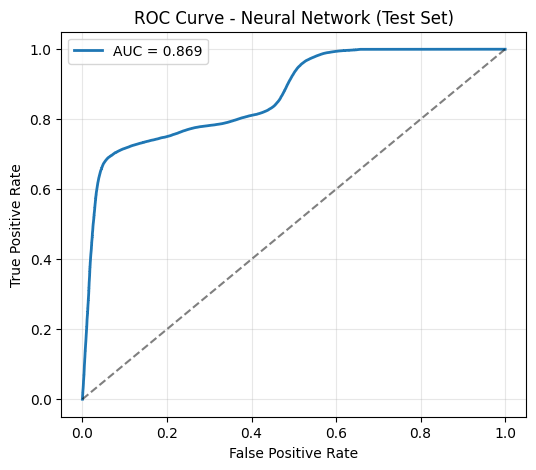

Biểu đồ ROC đã được lưu: roc_curve_neural_network.png


In [ ]:
# Trực quan hóa: ROC Curve
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_test_proba_nn)
plt.plot(fpr, tpr, label=f"AUC = {test_auc_nn:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_neural_network.png')
plt.show()
print("Biểu đồ ROC đã được lưu: roc_curve_neural_network.png")

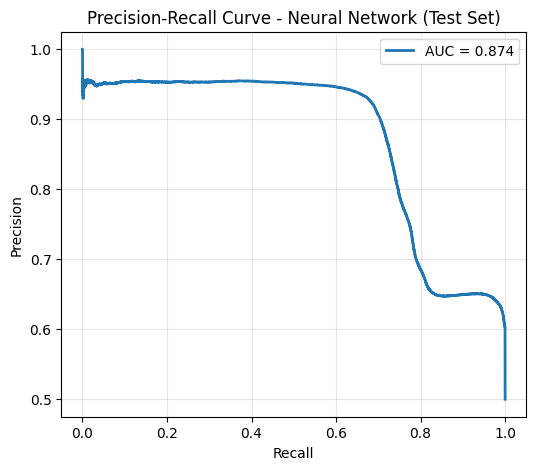

Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_neural_network.png


In [ ]:
# Trực quan hóa: Precision-Recall Curve
plt.figure(figsize=(6, 5))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_nn)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}", linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Neural Network (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall_curve_neural_network.png')
plt.show()
print("Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_neural_network.png")

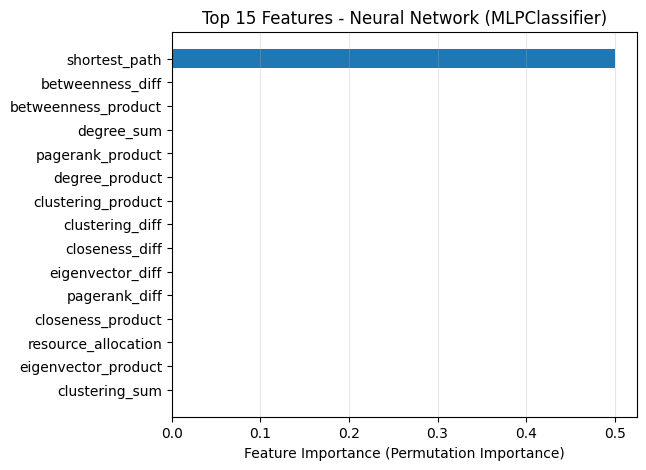

Biểu đồ Feature Importance đã được lưu: feature_importance_neural_network.png


In [ ]:
# Tính toán permutation importance
perm_importance = permutation_importance(model_nn, X_train_scaled, y_train, n_repeats=10, random_state=42)

# Tạo DataFrame cho feature importance
feature_importance = pd.DataFrame({
    'feature': train_features.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=True).tail(15)

# Trực quan hóa
plt.figure(figsize=(6, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance (Permutation Importance)')
plt.title('Top 15 Features - Neural Network (MLPClassifier)')
plt.grid(True, alpha=0.3, axis='x')
plt.savefig('feature_importance_neural_network.png')
plt.show()
print("Biểu đồ Feature Importance đã được lưu: feature_importance_neural_network.png")

### XGBoost

In [3]:
import xgboost as xgb

In [4]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
model_xgb = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Định nghĩa mô hình
model_xgb = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Huấn luyện
model_xgb.fit(X_train_scaled, y_train)

# Dự đoán
y_val_pred_xgb = model_xgb.predict(X_val_scaled)
y_val_proba_xgb = model_xgb.predict_proba(X_val_scaled)[:, 1]

y_test_pred_xgb = model_xgb.predict(X_test_scaled)
y_test_proba_xgb = model_xgb.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Đánh giá
val_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
test_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

print(f"XGBoost - Validation AUC: {val_auc_xgb:.4f}")
print(f"XGBoost - Test AUC: {test_auc_xgb:.4f}")

XGBoost - Validation AUC: 0.5000
XGBoost - Test AUC: 0.5000


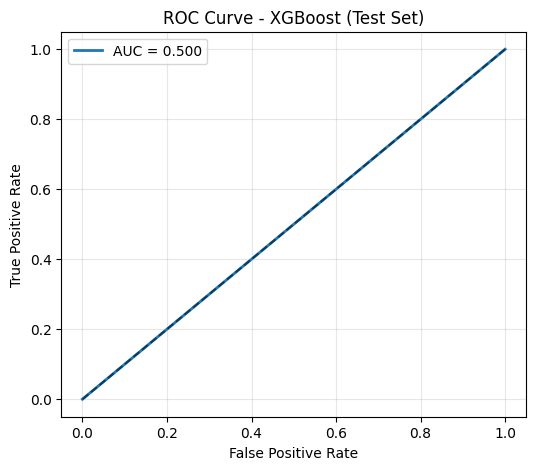

Biểu đồ ROC đã được lưu: roc_curve_xgboost.png


In [ ]:
# Trực quan hóa: ROC Curve
plt.figure(figsize=(6, 5))
fpr, tpr, _ = roc_curve(y_test, y_test_proba_xgb)
plt.plot(fpr, tpr, label=f"AUC = {test_auc_xgb:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_xgboost.png')
plt.show()
print("Biểu đồ ROC đã được lưu: roc_curve_xgboost.png")

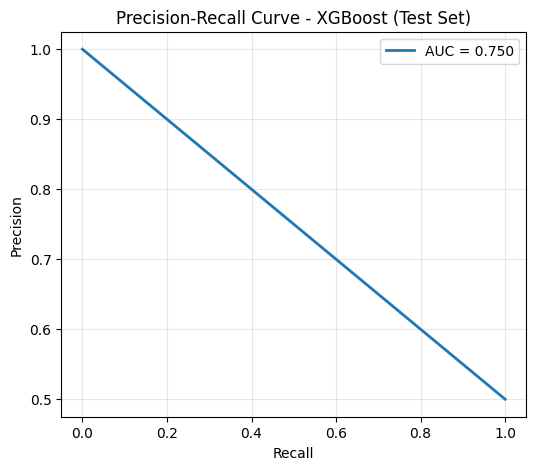

Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_xgboost.png


In [ ]:
# Trực quan hóa: Precision-Recall Curve
plt.figure(figsize=(6, 5))
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_xgb)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}", linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall_curve_xgboost.png')
plt.show()
print("Biểu đồ Precision-Recall đã được lưu: precision_recall_curve_xgboost.png")

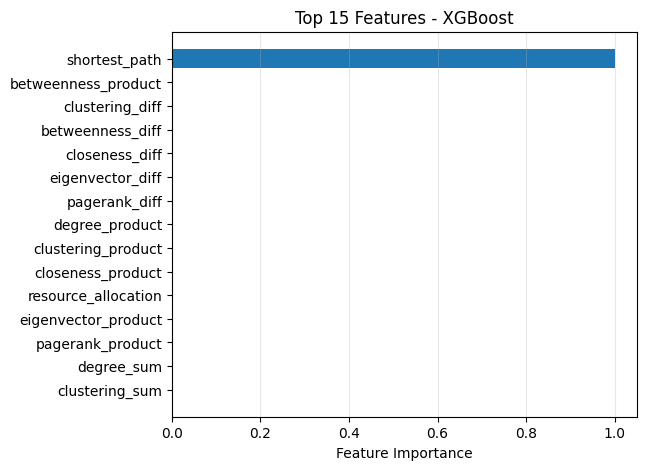

Biểu đồ Feature Importance đã được lưu: feature_importance_xgboost.png


In [ ]:
# Trực quan hóa: Feature Importance
plt.figure(figsize=(6, 5))
feature_importance = pd.DataFrame({
    'feature': train_features.columns,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=True).tail(15)
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - XGBoost')
plt.grid(True, alpha=0.3, axis='x')
plt.savefig('feature_importance_xgboost.png')
plt.show()
print("Biểu đồ Feature Importance đã được lưu: feature_importance_xgboost.png")


### SVM

In [ ]:
# Định nghĩa mô hình
model_svm = SVC(probability=True, random_state=42)

# Huấn luyện
model_svm.fit(X_train_scaled, y_train)

# Dự đoán
y_val_pred_svm = model_svm.predict(X_val_scaled)
y_val_proba_svm = model_svm.predict_proba(X_val_scaled)[:, 1]

y_test_pred_svm = model_svm.predict(X_test_scaled)
y_test_proba_svm = model_svm.predict_proba(X_test_scaled)[:, 1]

SVM - Validation AUC: 0.5018
SVM - Test AUC: 0.5016


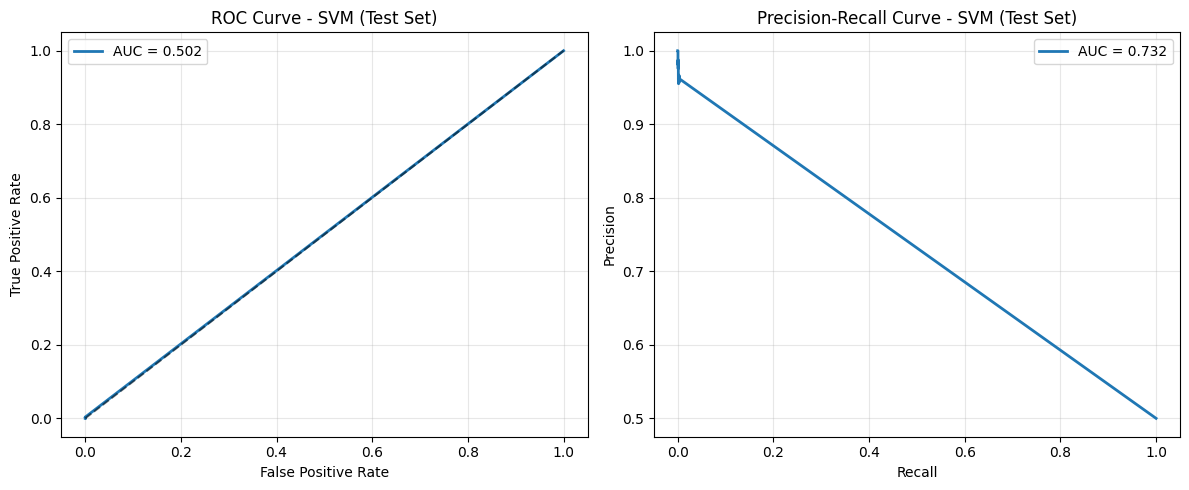

Biểu đồ đã được lưu: svm_visualization.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Đánh giá
val_auc_svm = roc_auc_score(y_val, y_val_proba_svm)
test_auc_svm = roc_auc_score(y_test, y_test_proba_svm)

print(f"SVM - Validation AUC: {val_auc_svm:.4f}")
print(f"SVM - Test AUC: {test_auc_svm:.4f}")

# Trực quan hóa: ROC Curve và Precision-Recall Curve cho Test Set
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_svm)
axes[0].plot(fpr, tpr, label=f"AUC = {test_auc_svm:.3f}", linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - SVM (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_svm)
pr_auc = auc(recall, precision)
axes[1].plot(recall, precision, label=f"AUC = {pr_auc:.3f}", linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - SVM (Test Set)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svm_visualization.png')
plt.show()

# Lưu biểu đồ
print("Biểu đồ đã được lưu: svm_visualization.png")

### GAE

In [ ]:
## Transform the graph to feed to GAE
data = from_networkx(G_full)
data.x = torch.eye(data.num_nodes)

In [ ]:
## Split train test
data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)

In [ ]:
## Initalize the GAE model
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [ ]:
## Fine-tune parameter
in_channels = data.num_features
out_channels = 16

## Pass the parameter
model = GAE(GCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    # Get node embeddings from the encoder
    z = model.encode(data.x, data.train_pos_edge_index)
    # Calculate reconstruction loss
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)


In [ ]:
## Training model
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print("Training complete!")

Epoch: 020, Loss: 0.7925
Epoch: 040, Loss: 0.6892
Epoch: 060, Loss: 0.6608
Epoch: 080, Loss: 0.5975
Epoch: 100, Loss: 0.5888
Epoch: 120, Loss: 0.5881
Epoch: 140, Loss: 0.5784
Epoch: 160, Loss: 0.5497
Epoch: 180, Loss: 0.5359
Epoch: 200, Loss: 0.5316
Training complete!


In [ ]:
## Evaluate
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.train_pos_edge_index)

# Print mesurement
auc_1, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)
print(f'AUC: {auc_1:.4f}, AP: {ap:.4f}')

AUC: 0.9990, AP: 0.9992


In [ ]:
def plot_roc_curve(model, z, pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():



        # 1. Get the predicted probabilities for both positive and negative edges
        pos_scores = model.decoder(z, pos_edge_index, sigmoid=True)
        neg_scores = model.decoder(z, neg_edge_index, sigmoid=True)

        # 2. Combine scores and create true labelss
        scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()
        labels = torch.cat(
            [torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])]
        ).cpu().numpy()

        # 3. Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(labels, scores)
        roc_auc_score = auc(fpr, tpr)

        # 4. Plot the curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'GAE Model (AUC = {roc_auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


In [ ]:
# Kiểm tra xem auc có phải là hàm hay không
print(auc)  # Nên in ra: <function auc at ...>
print(type(auc))  # Nên in ra: <class 'function'>

<function auc at 0x000001EF3648B240>
<class 'function'>


In [ ]:
all_edges = set(tuple(sorted(edge)) for edge in G_full.edges())
possible_non_edges = []
scores = []

# Calculate scores for all node pairs that are not already connected

## Z is the node embedding matrix ([num_nodes, embedding_dim])
## adj perform matrix multiiplication and use sigmoid to output 1 or 0
adj = (z @ z.T).sigmoid().cpu().numpy()
for i in range(data.num_nodes):
    for j in range(i + 1, data.num_nodes):
        if tuple(sorted((i, j))) not in all_edges:
            possible_non_edges.append((i, j))
            scores.append(adj[i, j])

In [ ]:
# Get the top 5 predictions
top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]
top_5_predictions = [possible_non_edges[i] for i in top_indices]

print("\nTop 5 predicted new links:")
for i, edge in enumerate(top_5_predictions):
    print(f"{i+1}. Node {edge[0]} - Node {edge[1]} (Score: {scores[top_indices[i]]:.4f})")


Top 5 predicted new links:
1. Node 558 - Node 1898 (Score: 1.0000)
2. Node 1898 - Node 2331 (Score: 1.0000)
3. Node 53 - Node 1898 (Score: 1.0000)
4. Node 558 - Node 2331 (Score: 1.0000)
5. Node 860 - Node 1898 (Score: 1.0000)


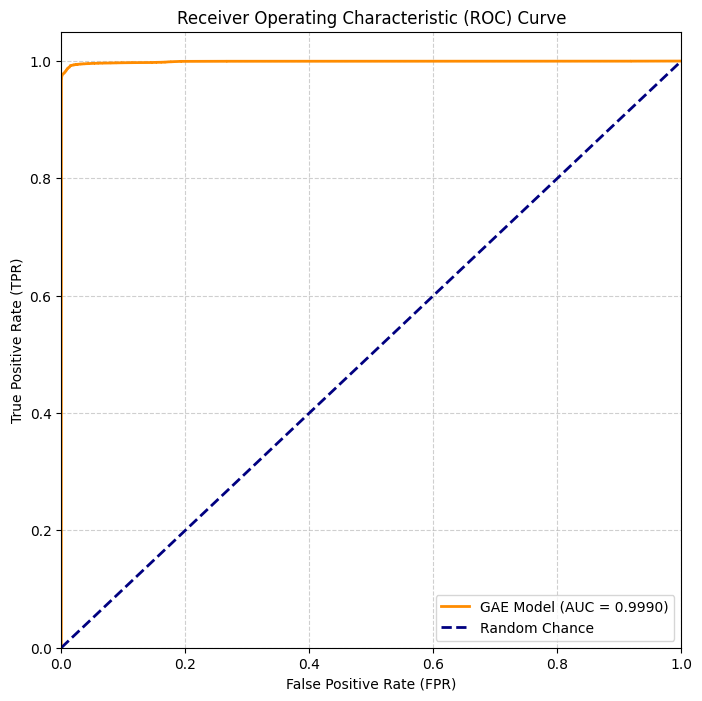

In [ ]:
plot_roc_curve(model, z, data.test_pos_edge_index, data.test_neg_edge_index)